In [96]:
library(glue)
library(tidyr)
library(dplyr)
library(scales)
library(ggplot2)
library(ggthemes)
library(tidyverse)

In [97]:
# the usa_1910_current.csv is not being checked in as part of this repo,
# it can be downloaded from the bigquery-public-data.usa_names fataset in Google BigQuery
usa_names <- read_csv("usa_1910_current.csv",
                      col_types=cols(state = col_character(),
                                      gender = col_character(),
                                      year = col_double(),
                                      name = col_character(),
                                      number = col_double()
                                    )) %>%
               mutate(gender=case_when(gender=='M' ~ "Male",
                                       gender=='F' ~ "Female",
                                       TRUE ~ "Other"))
head(usa_names)

state,gender,year,name,number
<chr>,<chr>,<dbl>,<chr>,<dbl>
MI,Female,1910,Helen,368
MI,Female,1910,Mary,349
MI,Female,1910,Margaret,272
MI,Female,1910,Dorothy,265
MI,Female,1910,Ruth,212
MI,Female,1910,Florence,164


In [98]:
# top 10 most popular names of all time
top10_most_popular_names <- usa_names %>%
  group_by(gender, name) %>%
  summarize(count=sum(number, na.rm=TRUE)) %>%
  collect() %>%
  arrange(desc(count), `.by_group` = TRUE) %>%
  mutate(rank=row_number()) %>%
  filter(rank <= 10)

head(top10_most_popular_names, 20)

`summarise()` has grouped output by 'gender'. You can override using the `.groups` argument.



gender,name,count,rank
<chr>,<chr>,<dbl>,<int>
Female,Mary,3743561,1
Female,Patricia,1569296,2
Female,Elizabeth,1545720,3
Female,Jennifer,1466943,4
Female,Linda,1448280,5
Female,Barbara,1424504,6
Female,Margaret,1133157,7
Female,Susan,1109542,8
Female,Dorothy,1053909,9


In [99]:
ds_start_year <- min(usa_names$year, na.rm=TRUE)
ds_end_year <- max(usa_names$year, na.rm=TRUE)

print(glue("ds_start_year={ds_start_year}, ds_end_year={ds_end_year}"))

ds_start_year=1910, ds_end_year=2019


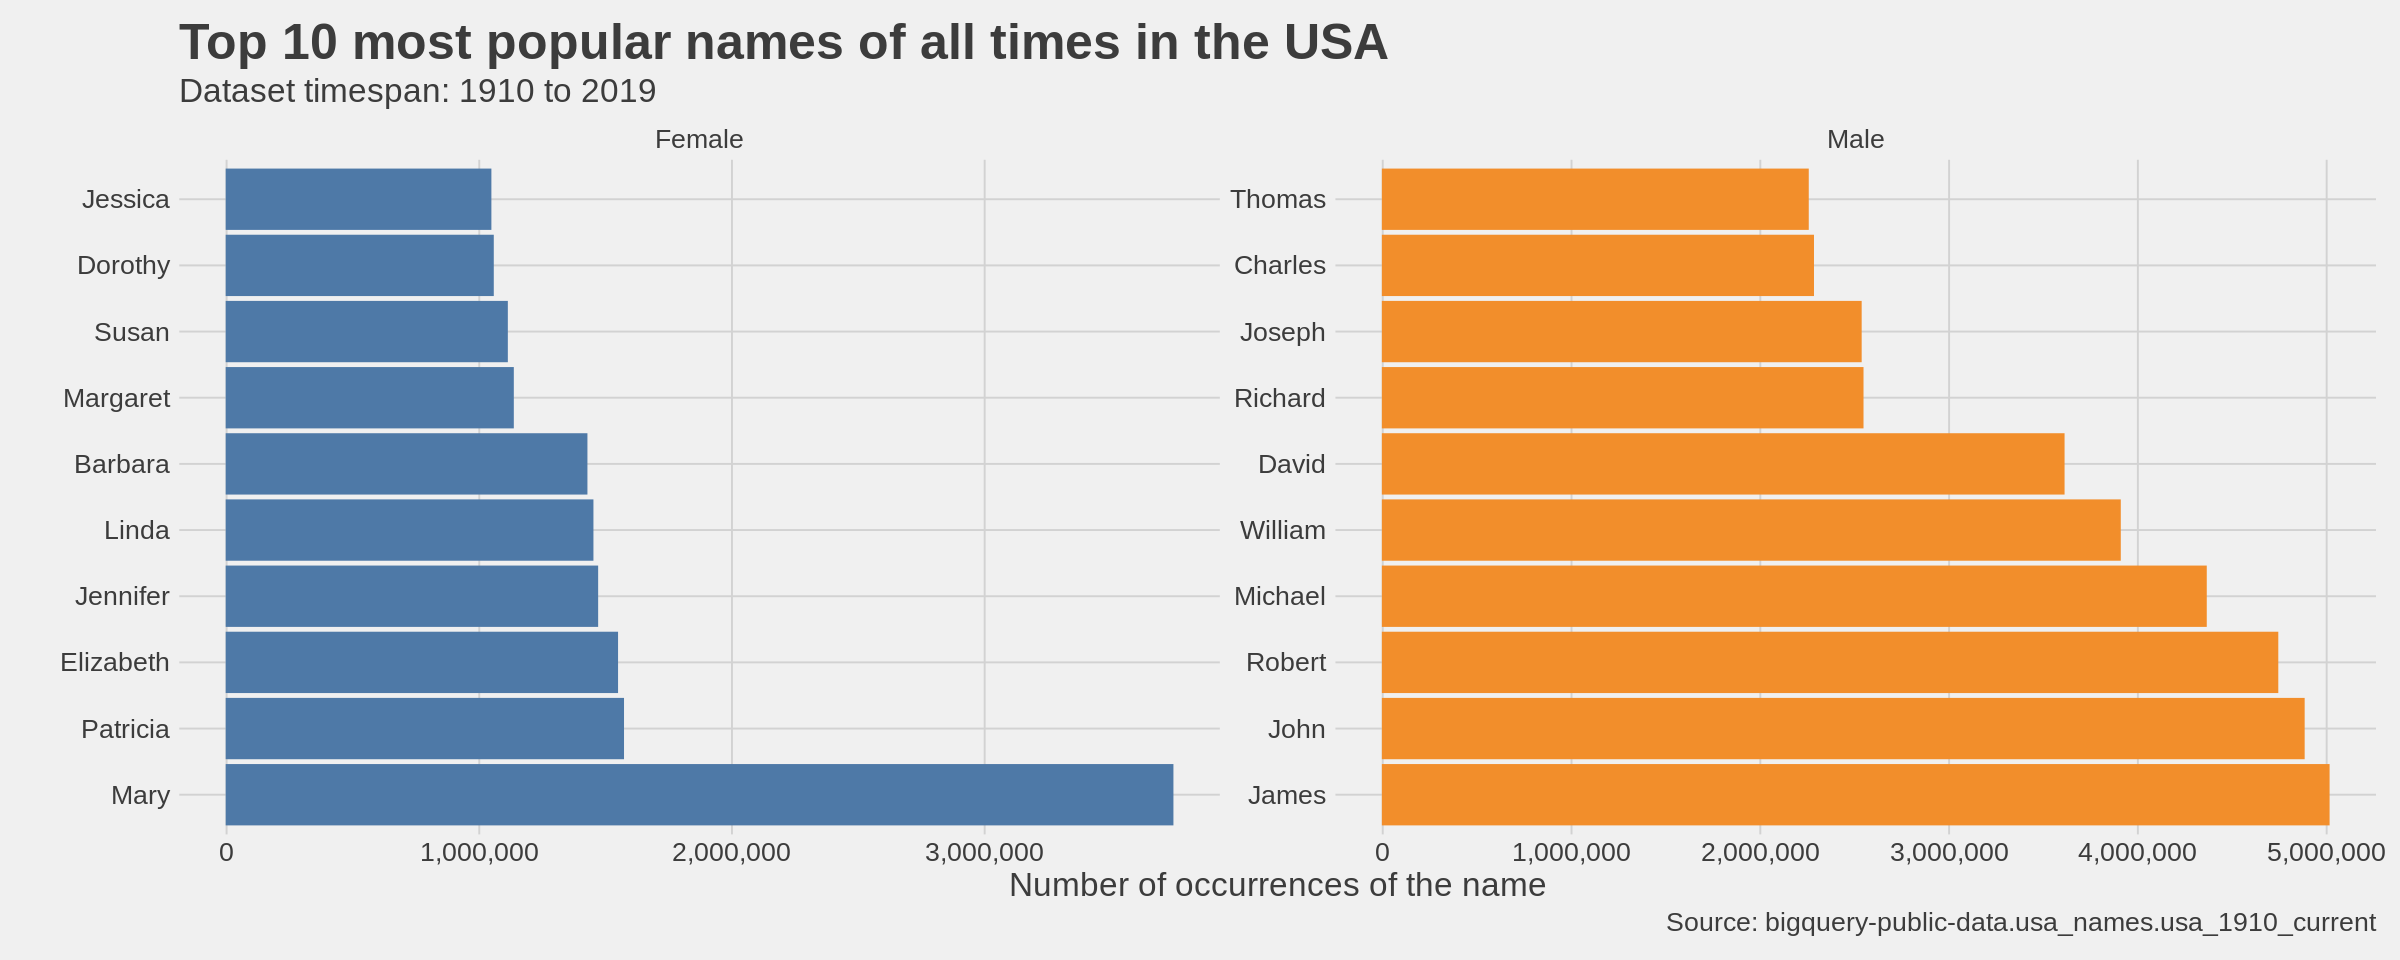

In [101]:
options(repr.plot.width=20, repr.plot.height=8)

title <- "Top 10 most popular names of all times in the USA"
subtitle <- glue("Dataset timespan: {ds_start_year} to {ds_end_year} ")
caption <- "Source: bigquery-public-data.usa_names.usa_1910_current"
top10_most_popular_names %>%
  ggplot(aes(x=reorder(name, -count), y=count, col=gender, fill=gender)) + 
  geom_bar(stat='identity') +
  facet_wrap(~gender, scales="free") +
  scale_y_continuous(labels = comma) +
  theme_fivethirtyeight() +
  scale_color_tableau() +
  scale_fill_tableau() +
  coord_flip() +
  labs(title=title,
       subtitle=subtitle,
        caption=caption) +
  theme(legend.position="none") +
  theme(text = element_text(size=20)) +
  theme(axis.title = element_text()) +
  ylab("Number of occurrences of the name") + xlab("")

`summarise()` has grouped output by 'year', 'gender'. You can override using the `.groups` argument.



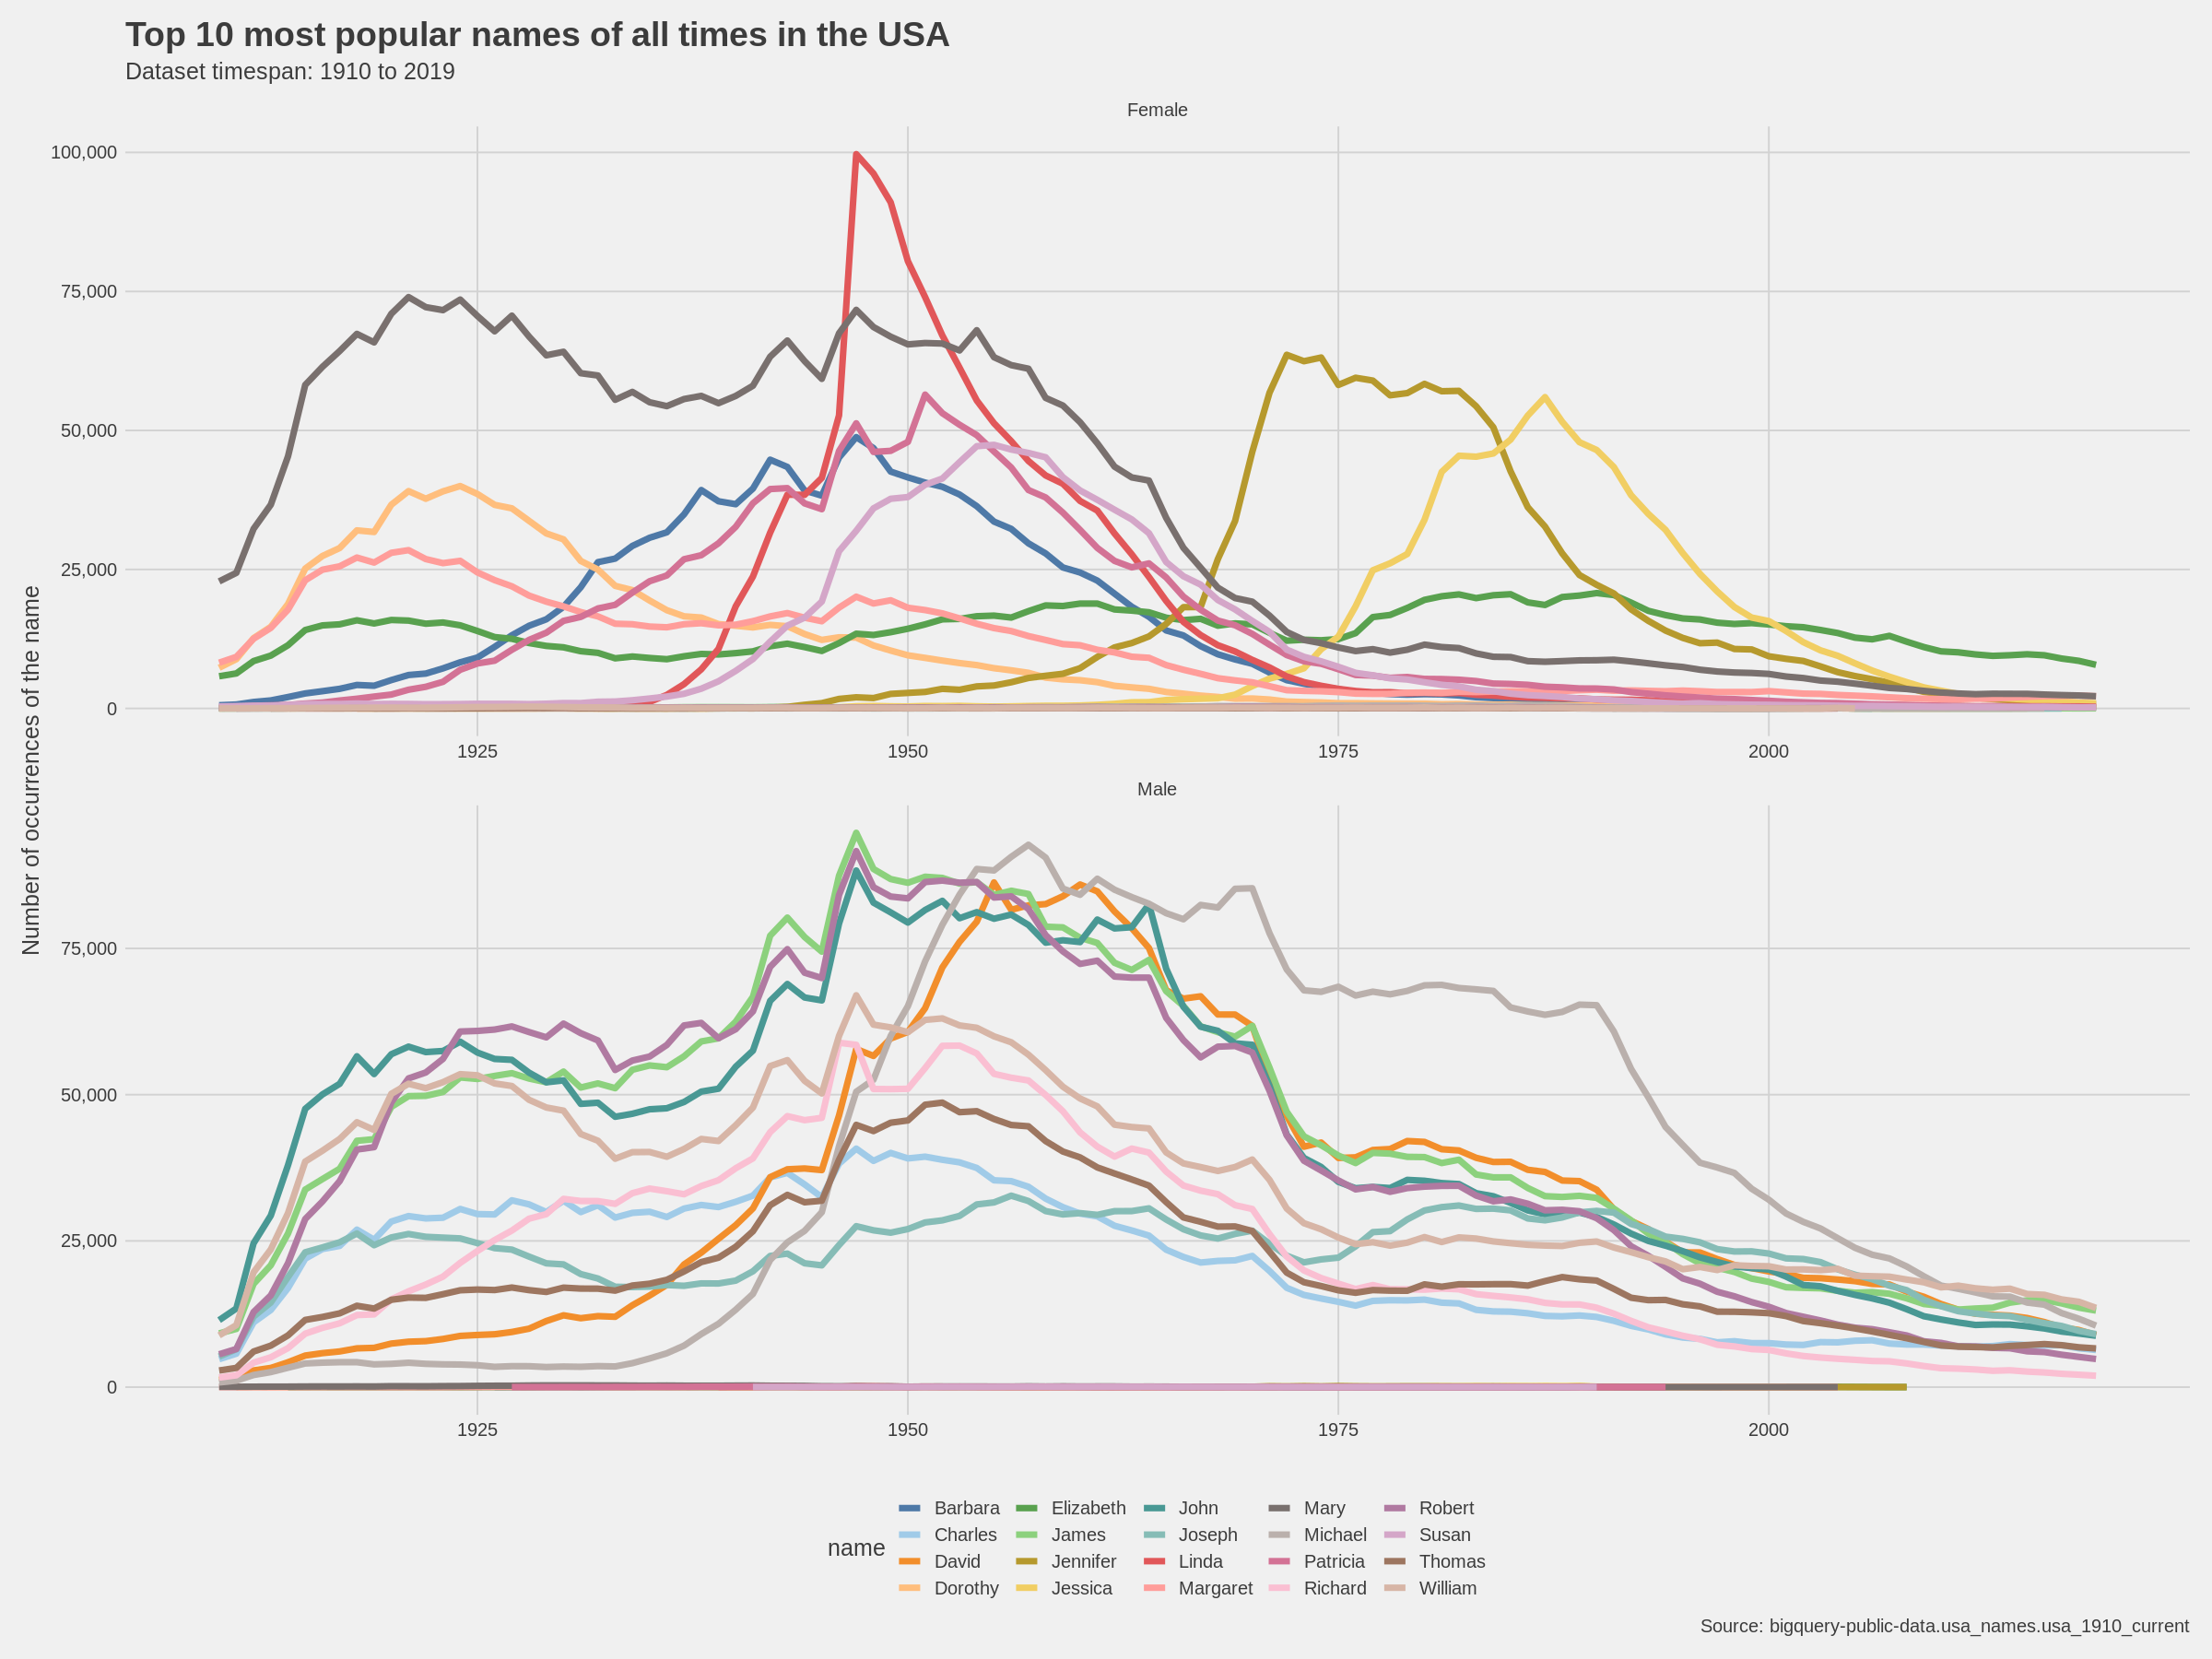

In [103]:
# how are the most popular names of all times faring now?
options(repr.plot.width=20, repr.plot.height=15)

usa_names %>%
  filter(name %in% c(top10_most_popular_names$name)) %>%
  group_by(year, gender, name) %>%
  summarize(count=sum(number)) %>%
  ggplot(aes(x=year, y=count, col=name)) +
  geom_line(size=2) + 
  facet_wrap(~gender, scales="free", ncol=1) +
  scale_y_continuous(labels = comma) +
  theme_fivethirtyeight() +
  scale_color_tableau(palette="Tableau 20") +
  scale_fill_tableau(palette="Tableau 20") +
  labs(title=title,
       subtitle=subtitle,
        caption=caption) +
  theme(legend.position="bottom") +
  theme(text = element_text(size=15)) +
  theme(axis.title = element_text()) +
  ylab("Number of occurrences of the name") + xlab("")

In [104]:
# what are the top 10 names gaining in popularity in the 2010s?
names_gaining_in_popularity <- usa_names %>%
  filter(year >=2010 & year <= 2019) %>%
  group_by(year, gender, name) %>%
  summarize(count = sum(number)) %>%
  ungroup() %>%
  arrange(desc(year)) %>%
  group_by(gender, name) %>%
  mutate(diff_from_prev = count-lead(count)) %>%
  filter(!is.na(diff_from_prev)) %>%
  ungroup() %>%
  group_by(gender, name) %>%
  summarize(trend = sum(diff_from_prev)) %>%
  ungroup() %>%
  group_by(gender) %>%
  slice_max(order_by = trend, n = 10)

head(names_gaining_in_popularity, 20)

`summarise()` has grouped output by 'year', 'gender'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gender'. You can override using the `.groups` argument.



gender,name,trend
<chr>,<chr>,<dbl>
Female,Harper,7809
Female,Charlotte,7784
Female,Amelia,7403
Female,Luna,6843
Female,Mila,6461
Female,Aria,6190
Female,Penelope,5165
Female,Everly,4660
Female,Evelyn,4552


`summarise()` has grouped output by 'year', 'gender'. You can override using the `.groups` argument.



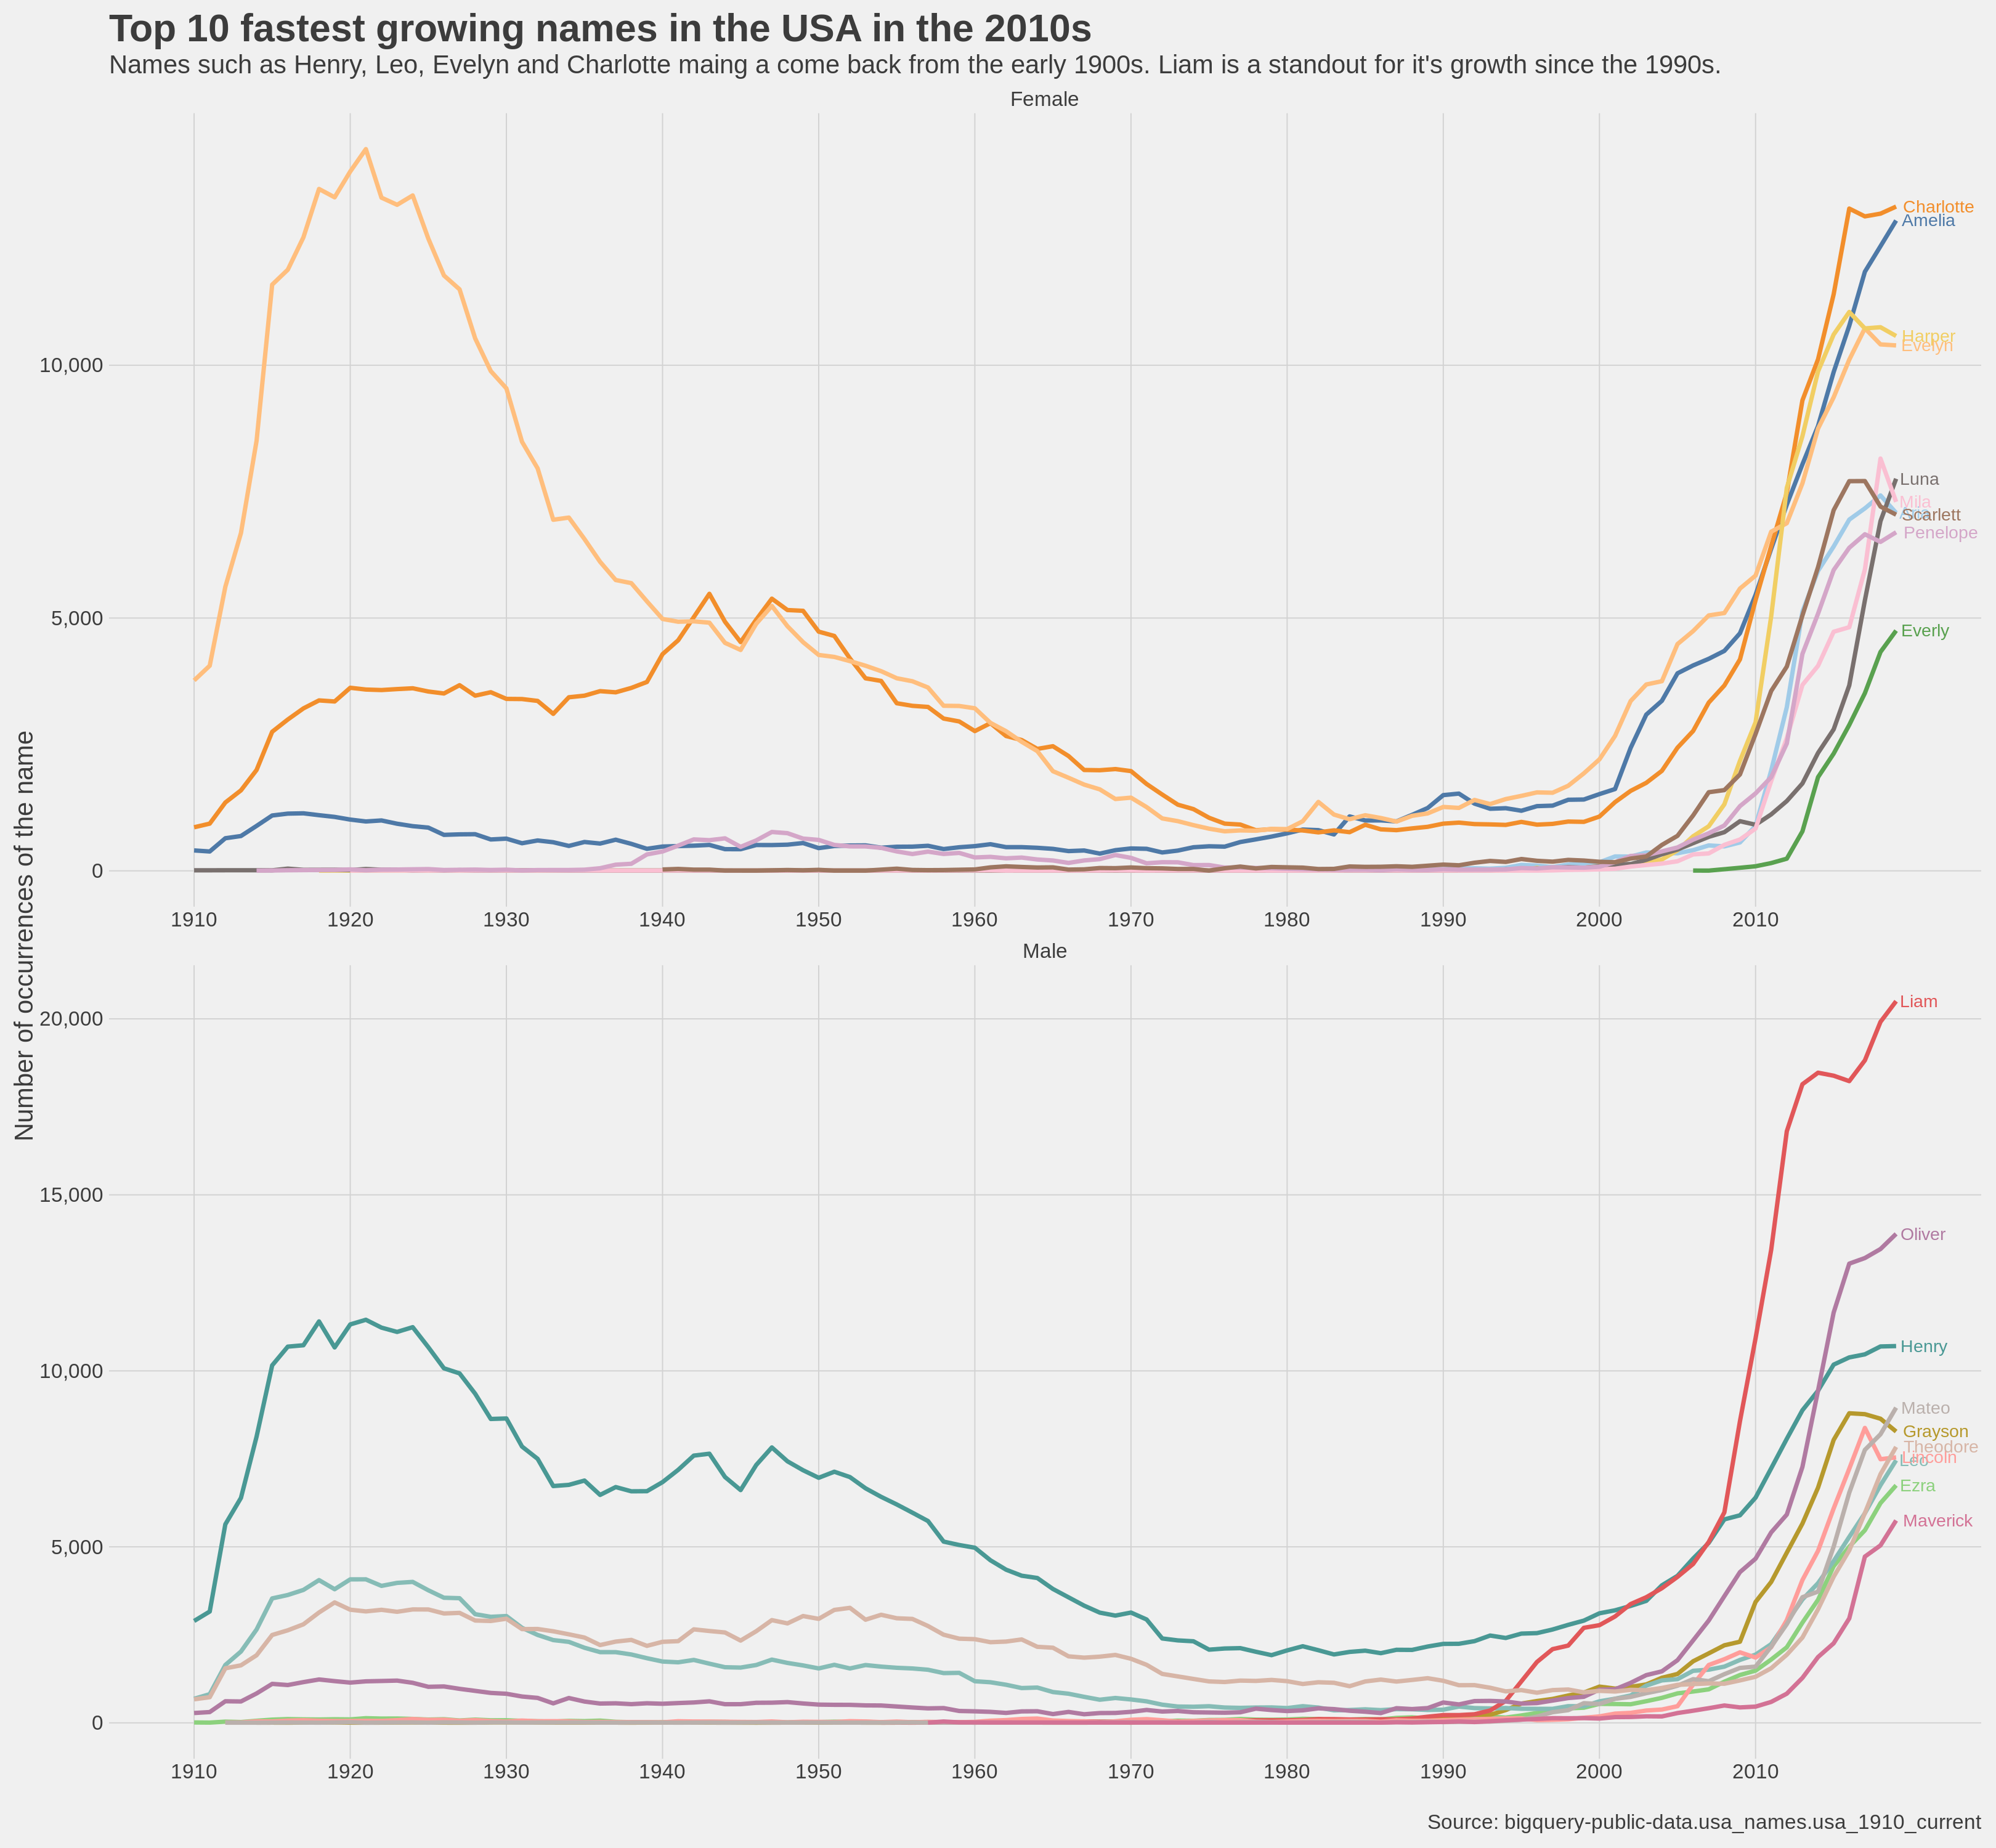

In [105]:
options(repr.plot.width=27, repr.plot.height=25)

popular_names_2010s <- usa_names %>%
  filter(name %in% names_gaining_in_popularity$name) %>%
  select(-gender) %>%
  left_join(names_gaining_in_popularity %>% select(name, gender), by="name") %>%
  group_by(year, gender, name) %>%
  summarize(count=sum(number)) 
  
title <- "Top 10 fastest growing names in the USA in the 2010s" 
subtitle <- "Names such as Henry, Leo, Evelyn and Charlotte maing a come back from the early 1900s. Liam is a standout for it's growth since the 1990s."
popular_names_2010s %>%
  ggplot(aes(x=year, y=count, col=name)) +
  geom_line(size=2) + 
  geom_text(data = subset(popular_names_2010s, year == 2019), 
            aes(label = name, colour = name, x = 2019, y = count), 
            hjust = -.1, size=6) +
  facet_wrap(~gender, scales="free", ncol=1) +
  scale_y_continuous(labels = comma) +
  scale_x_continuous(breaks=seq(ds_start_year, ds_end_year, 10)) +
  theme_fivethirtyeight() +
  scale_color_tableau(palette="Tableau 20") +
  scale_fill_tableau(palette="Tableau 20") +
  labs(title=title,
       subtitle=subtitle,
        caption=caption) +
  theme(legend.position="none") +
  theme(text = element_text(size=25)) +
  theme(axis.title = element_text()) +
  ylab("Number of occurrences of the name") + xlab("")